# Data import and analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64

df = pd.read_csv('angles_pose_dataset.csv')
df = df.drop(df.columns[0], axis=1)
df = df.drop('image_name', axis=1)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959 entries, 0 to 958
Data columns (total 5 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   angle_rightHip_rightShoulder_rightElbow    959 non-null    float64
 1   angle_leftHip_leftShoulder_leftElbow       959 non-null    float64
 2   angle_rightShoulder_rightElbow_rightWrist  959 non-null    float64
 3   angle_leftShoulder_leftElbow_leftWrist     959 non-null    float64
 4   label                                      959 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 37.6 KB


### Label distribution

Original dataset

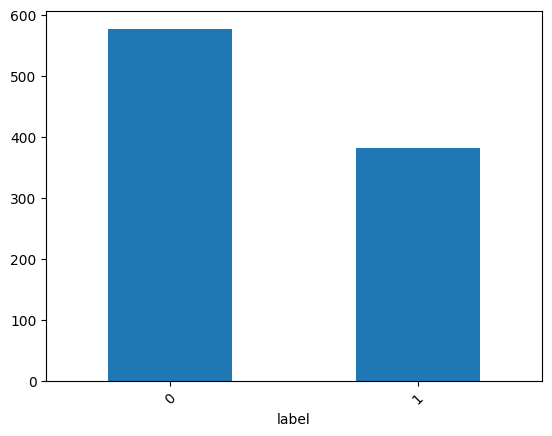

In [3]:
df.label.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

Extract balanced dataset

Samples per class: 382


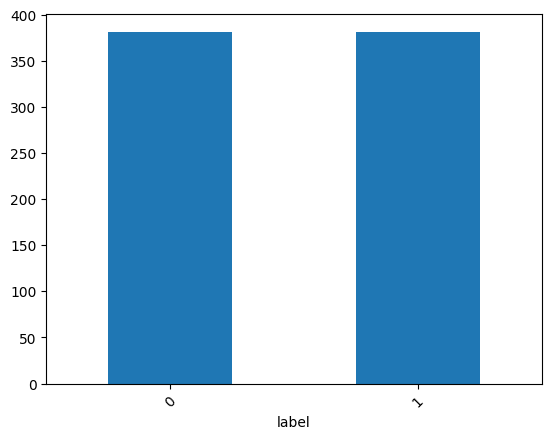

In [4]:
class_counts = df.groupby('label').size()
min_class_count = class_counts.min() # Class with the lowest number of rows

# Extract the same number of rows for each class
balanced_data = pd.DataFrame()
for label, group in df.groupby('label'):
    balanced_data = pd.concat([balanced_data, group.sample(n=min_class_count)])

print("Samples per class:", balanced_data.label.value_counts()[0])
balanced_data.label.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

### Split dataset

In [5]:
y = balanced_data['label']
X = balanced_data.drop('label', axis=1)

# Split train test validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_loader = DataLoader(list(zip(X_train.values, y_train.values)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(X_test.values, y_test.values)), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(list(zip(X_val.values, y_val.values)), batch_size=batch_size, shuffle=False)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])
print("Validation size:", X_val.shape[0])

Train size: 488
Test size: 153
Validation size: 123


# Define and train model

In [6]:
class PoseClassifier(nn.Module):
    def __init__(self):
        super(PoseClassifier, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [7]:
model = PoseClassifier()
learning_rate = 0.01
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

model.to(device)
criterion.to(device)

BCEWithLogitsLoss()

In [8]:
max_epochs = 100
best_val_accuracy = 0
patience = 10
epochs_no_improve = 0
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs.float()).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Train loss: {running_loss / len(train_loader)}")

    model.eval()
    correct = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs.float()).squeeze()
            predicted = torch.round(torch.sigmoid(outputs))

            correct += (predicted == labels).sum().item()
    
    val_accuracy = correct / len(val_loader.dataset)
    print(f"Validation Accuracy: {val_accuracy}")
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'classifier.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping")
            break
print("Finished training, best validation accuracy:", best_val_accuracy)

Epoch 1, Train loss: 0.4454740211367607
Validation Accuracy: 0.975609756097561
Epoch 2, Train loss: 0.12399985874071717
Validation Accuracy: 0.991869918699187
Epoch 3, Train loss: 0.07166934199631214
Validation Accuracy: 1.0
Epoch 4, Train loss: 0.048811251763254404
Validation Accuracy: 0.975609756097561
Epoch 5, Train loss: 0.05993239738745615
Validation Accuracy: 0.991869918699187
Epoch 6, Train loss: 0.06899923150194809
Validation Accuracy: 1.0
Epoch 7, Train loss: 0.057844916358590126
Validation Accuracy: 0.991869918699187
Epoch 8, Train loss: 0.05325792683288455
Validation Accuracy: 0.991869918699187
Epoch 9, Train loss: 0.050433110212907195
Validation Accuracy: 0.991869918699187
Epoch 10, Train loss: 0.0625905446941033
Validation Accuracy: 0.975609756097561
Epoch 11, Train loss: 0.06900225533172488
Validation Accuracy: 0.991869918699187
Epoch 12, Train loss: 0.06584430579096079
Validation Accuracy: 0.975609756097561
Epoch 13, Train loss: 0.057514111744239926
Validation Accuracy: 

# Test

Load the best model

In [9]:
model.load_state_dict(torch.load('classifier.pt'))

<All keys matched successfully>

In [10]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs.float())
        preds = outputs > 0
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [11]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        80
           1       0.97      1.00      0.99        73

    accuracy                           0.99       153
   macro avg       0.99      0.99      0.99       153
weighted avg       0.99      0.99      0.99       153



# Export as onnx

In [12]:
dummy_input = torch.randn(1, 4)  # Adjust the dimensions according to your model's input

torch.onnx.export(
    model,
    dummy_input,
    "classifier.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'},
                  'output': {0: 'batch_size'}}
)